# Disease Outbreak Predictor
Course: CPE 3018 – Numerical Methods
Project: Data-Driven Disease Outbreak Predictor
Language: Python (Jupyter Notebook)

Overview
This notebook implements a disease outbreak predictor based on Newton's Divided Difference Method. It:
1. Uses a small number of time-based data points (days vs. cases/deaths).
2. Builds an interpolating polynomial using divided differences.
3. Performs:
 - Interpolation (estimating missing data within the time range).
 - Extrapolation (estimating future cases beyond the time range).
4. Applies error analysis concepts from Numerical Methods:
 - Absolute and relative error
 - Truncation error (via theoretical error bounds)
5. Error propagation ideas
6. Provides plots of:
 - Observed data
 - Interpolated curve
 - Extrapolated future predictions
 - Error bounds
 - Case fatality rate

In [1]:
# 1. IMPORT REQUIRED LIBRARIES
# ----------------------------
# We import numerical and plotting libraries that will be used throughout
# the notebook. These are all standard for scientific Python.

import numpy as np           # For numerical computations, arrays, math
import pandas as pd          # For tabular display and basic data manipulation
import matplotlib.pyplot as plt  # For plotting and visualization
import warnings

# We suppress non-critical warnings to keep the output clean.
warnings.filterwarnings('ignore')

# Improve readability of NumPy and pandas outputs
np.set_printoptions(precision=6, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Newton's Divided Difference Method Implementation
This section implements the interpolation method discussed under Interpolation, Extrapolation, and Polynomial Approximation – Divided Difference Method.

In [2]:
# 2. NEWTON'S DIVIDED DIFFERENCE IMPLEMENTATION
# ---------------------------------------------
# This class implements the Newton Divided Difference method. It constructs the
# divided differences table and provides a function to evaluate the resulting
# interpolating polynomial for any x (for interpolation or extrapolation).

class NewtonDividedDifference:
    """
    Newton's Divided Difference Interpolation Method

    This class implements the Newton's divided difference method for polynomial
    interpolation and extrapolation of outbreak data.

    Attributes:
        x_data (np.array): Time points (independent variable)
        y_data (np.array): Case/death counts (dependent variable)
        n (int): Number of data points
        divided_diff_table (np.array): 2D array of divided differences
    """

    def __init__(self, x_data, y_data):
        """
        Initialize the Newton Divided Difference interpolator.

        Args:
            x_data (list/array): Time values (e.g., days)
            y_data (list/array): Case or death counts
        """
        self.x_data = np.array(x_data, dtype=float)
        self.y_data = np.array(y_data, dtype=float)
        self.n = len(self.x_data)

        # Basic input validation
        if len(self.x_data) != len(self.y_data):
            raise ValueError("x_data and y_data must have the same length")
        if self.n < 2:
            raise ValueError("At least 2 data points are required")

        # Sort data by x-values to maintain proper order
        sorted_indices = np.argsort(self.x_data)
        self.x_data = self.x_data[sorted_indices]
        self.y_data = self.y_data[sorted_indices]

        # Compute the divided differences table once at initialization
        self.divided_diff_table = self._compute_divided_differences()

    def _compute_divided_differences(self):
        """
        Compute the divided differences table.

        The table is n x n, where:
        - Column 0: f[x_i] (the original function values)
        - Column 1: f[x_i, x_{i+1}] (first-order divided differences)
        - Column 2: f[x_i, x_{i+1}, x_{i+2}] (second-order), etc.

        Time Complexity: O(n^2)
        Space Complexity: O(n^2)

        Returns:
            np.array: (n x n) divided differences table
        """
        # Initialize with zeros and put function values in the first column
        diff_table = np.zeros((self.n, self.n))
        diff_table[:, 0] = self.y_data

        # Fill the rest of the table using the divided difference formula
        for j in range(1, self.n):      # column (order of difference)
            for i in range(self.n - j):  # row
                numerator = diff_table[i+1, j-1] - diff_table[i, j-1]
                denominator = self.x_data[i+j] - self.x_data[i]
                diff_table[i, j] = numerator / denominator

        return diff_table

    def evaluate(self, x):
        """
        Evaluate the Newton interpolating polynomial at one or more points.

        Uses a Horner-like nested scheme for efficiency:
        P(x) = a_0 + (x-x_0)[a_1 + (x-x_1)[a_2 + ...]]

        Args:
            x (float or array): Point(s) at which to evaluate P(x)

        Returns:
            float or np.array: Interpolated (or extrapolated) values
        """
        x = np.atleast_1d(x)  # Convert scalar to array for uniform handling
        results = np.zeros_like(x, dtype=float)

        # Evaluate the polynomial at each x-value
        for idx, x_val in enumerate(x):
            # Start with the highest-order coefficient
            result = self.divided_diff_table[0, self.n - 1]

            # Horner-like scheme going backward through columns
            for j in range(self.n - 2, -1, -1):
                result = result * (x_val - self.x_data[j]) + self.divided_diff_table[0, j]

            results[idx] = result

        # If the input was scalar, return scalar; else return array
        return results if len(results) > 1 else results[0]

    def get_divided_differences_table(self):
        """
        Return the divided differences table as a nicely formatted DataFrame.

        Returns:
            pd.DataFrame: Table of divided differences labeled by x_i and order
        """
        df = pd.DataFrame(self.divided_diff_table[:, :],
                          index=[f'x_{i}={x:.0f}' for i, x in enumerate(self.x_data)])
        column_names = ['f[x_i]']
        for i in range(1, self.n):
            column_names.append(f'f[x_i...x_{i}]')
        df.columns = column_names[:self.n]
        return df


## Error Analysis Module
We now implement numerical error analysis concepts:
 - Absolute error
 - Relative error
 - Mean absolute error (MAE)
 - Root mean square error (RMSE)
 - A simple theoretical error bound estimate (related to truncation error)


In [3]:
# 3. ERROR ANALYSIS MODULE
# ------------------------
# This class contains static methods for computing different error metrics that
# are directly related to the Error Analysis topics in your Numerical Methods course.

class OutbreakErrorAnalysis:
    """
    Error Analysis for Disease Outbreak Predictions.

    Provides methods for:
    - Absolute Error
    - Relative Error
    - Mean Absolute Error (MAE)
    - Root Mean Square Error (RMSE)
    - Simple theoretical error bound estimate
    """

    @staticmethod
    def absolute_error(predicted, actual):
        """
        Compute absolute error: E_abs = |predicted - actual|

        Args:
            predicted (float/array): Predicted values
            actual (float/array): True or reference values

        Returns:
            float/array: Absolute errors
        """
        return np.abs(predicted - actual)

    @staticmethod
    def relative_error(predicted, actual):
        """
        Compute relative error: E_rel = |predicted - actual| / |actual|

        If actual is zero, we define the relative error as zero to avoid division by zero.

        Args:
            predicted (float/array): Predicted values
            actual (float/array): True values

        Returns:
            float/array: Relative errors
        """
        actual_arr = np.asarray(actual)
        predicted_arr = np.asarray(predicted)

        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.abs(predicted_arr - actual_arr) / np.abs(actual_arr)
            result = np.where(actual_arr == 0, 0, result)

        return result

    @staticmethod
    def mean_absolute_error(predicted, actual):
        """
        Compute Mean Absolute Error (MAE).

        MAE = (1/n) * Σ |predicted_i - actual_i|
        """
        return np.mean(OutbreakErrorAnalysis.absolute_error(predicted, actual))

    @staticmethod
    def root_mean_square_error(predicted, actual):
        """
        Compute Root Mean Square Error (RMSE).

        RMSE = sqrt( (1/n) * Σ (predicted_i - actual_i)^2 )
        """
        return np.sqrt(np.mean((predicted - actual) ** 2))

    @staticmethod
    def error_bound_estimate(x_data, y_data, x_eval):
        """
        Estimate a theoretical interpolation error bound at a point x_eval.

        Approximate formula based on higher-order derivative idea:

        |E(x)| ≈ (M / (n+1)!) * |Π (x_eval - x_i)|

        where M is (very roughly) estimated from the first differences.
        This is a simplified educational approximation.

        Args:
            x_data (array): Known x-values
            y_data (array): Known y-values
            x_eval (float): Point at which we estimate the error bound

        Returns:
            float: Estimated error bound at x_eval
        """
        x_data = np.asarray(x_data)
        y_data = np.asarray(y_data)
        n = len(x_data)

        # Rough estimate for M using max first derivative
        if n >= 2:
            approx_derivatives = np.diff(y_data) / np.diff(x_data)
            M_estimate = np.max(np.abs(approx_derivatives)) * 2.0
        else:
            M_estimate = 1.0

        # Product term Π |x_eval - x_i|
        prod_term = np.prod(np.abs(x_eval - x_data))

        # Compute (n+1)! in a simple loop
        factorial = 1
        for i in range(1, n + 2):
            factorial *= i

        error_bound = (M_estimate / factorial) * prod_term
        return error_bound


## Disease Outbreak Predictor Class
This class combines the interpolation and error analysis into a single predictor.

In [4]:
# 4. DISEASE OUTBREAK PREDICTOR CLASS
# -----------------------------------
# This class is the "main system" described in your proposal. It uses
# NewtonDividedDifference internally for cases and deaths and provides methods
# to:
# - input data
# - interpolate missing days
# - extrapolate future days
# - retrieve the divided difference tables

class DiseaseOutbreakPredictor:
    """
    Data-Driven Disease Outbreak Predictor

    Features:
        - Input time-based case and death data
        - Interpolate missing data within the observed range
        - Extrapolate future outbreak trends
        - Visualize and analyze predictions
    """

    def __init__(self):
        """Initialize with empty attributes that will be filled after data input."""
        self.days = None
        self.case_data = None
        self.death_data = None
        self.interpolator_cases = None
        self.interpolator_deaths = None
        self.case_predictions = {}
        self.death_predictions = {}

    def input_data(self, days, cases, deaths=None):
        """
        Input outbreak data.

        Args:
            days (list/array): Time values (days)
            cases (list/array): Case counts per day
            deaths (list/array, optional): Death counts per day

        Returns:
            dict: Summary of the input data
        """
        self.days = np.array(days, dtype=float)
        self.case_data = np.array(cases, dtype=float)

        if deaths is not None:
            self.death_data = np.array(deaths, dtype=float)

        # Create interpolators for cases (and deaths if provided)
        self.interpolator_cases = NewtonDividedDifference(self.days, self.case_data)

        if self.death_data is not None:
            self.interpolator_deaths = NewtonDividedDifference(self.days, self.death_data)

        return {
            'data_points': len(self.days),
            'day_range': f"Days {self.days.min():.0f} to {self.days.max():.0f}",
            'case_range': f"{self.case_data.min():.0f} to {self.case_data.max():.0f}",
            'has_death_data': self.death_data is not None
        }

    def interpolate(self, days_to_interpolate, data_type='cases'):
        """
        Interpolate values for given days within the data range.

        Args:
            days_to_interpolate (list/array): Days to interpolate (inside known range)
            data_type (str): 'cases' or 'deaths'

        Returns:
            np.array: Interpolated values
        """
        if data_type == 'cases':
            interpolator = self.interpolator_cases
        elif data_type == 'deaths':
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            interpolator = self.interpolator_deaths
        else:
            raise ValueError("data_type must be 'cases' or 'deaths'")

        days_to_interpolate = np.array(days_to_interpolate, dtype=float)
        predictions = interpolator.evaluate(days_to_interpolate)

        # Store predictions in dictionary (optional, for later use)
        if data_type == 'cases':
            self.case_predictions.update(dict(zip(days_to_interpolate, predictions)))
        else:
            self.death_predictions.update(dict(zip(days_to_interpolate, predictions)))

        return predictions

    def extrapolate(self, future_days, data_type='cases'):
        """
        Extrapolate values for days outside the observed data range.

        Note: Extrapolation becomes less reliable as we move further from the
        known interval.

        Args:
            future_days (list/array): Days to predict outside the observed range
            data_type (str): 'cases' or 'deaths'

        Returns:
            np.array: Extrapolated values (negative values are clamped to zero)
        """
        if data_type == 'cases':
            interpolator = self.interpolator_cases
        elif data_type == 'deaths':
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            interpolator = self.interpolator_deaths
        else:
            raise ValueError("data_type must be 'cases' or 'deaths'")

        future_days = np.array(future_days, dtype=float)
        predictions = interpolator.evaluate(future_days)

        # Disease counts cannot be negative, so we clamp negative values to zero.
        predictions = np.maximum(predictions, 0)

        if data_type == 'cases':
            self.case_predictions.update(dict(zip(future_days, predictions)))
        else:
            self.death_predictions.update(dict(zip(future_days, predictions)))

        return predictions

    def get_divided_differences_summary(self, data_type='cases'):
        """
        Get the divided differences table for cases or deaths.

        Args:
            data_type (str): 'cases' or 'deaths'

        Returns:
            pd.DataFrame: Divided differences table
        """
        if data_type == 'cases':
            return self.interpolator_cases.get_divided_differences_table()
        else:
            if self.interpolator_deaths is None:
                raise ValueError("Death data not available")
            return self.interpolator_deaths.get_divided_differences_table()


## Sample Data Preparation
We now create a sample outbreak dataset to demonstrate the algorithm.

In [5]:
# 5. SAMPLE DATA PREPARATION
# --------------------------
# We simulate a small dataset representing an outbreak with exponential-like growth.
# This mimics a real disease outbreak with sparse reporting (only some days observed).

print("="*70)
print("DISEASE OUTBREAK PREDICTOR - INITIALIZATION")
print("="*70)

predictor = DiseaseOutbreakPredictor()

# Observed days (sparse, at least 4 points as requested)
days_observed = [1, 3, 5, 7, 10]           # days
cases_observed = [50, 120, 280, 650, 1800]  # cases
deaths_observed = [2, 6, 15, 35, 95]        # deaths

print("\nInput Data Summary:")
print("-"*70)

summary = predictor.input_data(days_observed, cases_observed, deaths_observed)

print(f"Number of data points: {summary['data_points']}")
print(f"Time range: {summary['day_range']}")
print(f"Case range: {summary['case_range']}")
print(f"Death data available: {summary['has_death_data']}")

print("\nObserved Data:")
print("-"*70)
input_df = pd.DataFrame({
    'Day': days_observed,
    'Cases': cases_observed,
    'Deaths': deaths_observed
})
print(input_df.to_string(index=False))


DISEASE OUTBREAK PREDICTOR - INITIALIZATION

Input Data Summary:
----------------------------------------------------------------------
Number of data points: 5
Time range: Days 1 to 10
Case range: 50 to 1800
Death data available: True

Observed Data:
----------------------------------------------------------------------
 Day  Cases  Deaths
   1     50       2
   3    120       6
   5    280      15
   7    650      35
  10   1800      95


## Divided Differences Analysis
We inspect the divided difference tables for cases and deaths.

In [6]:
# 6. DIVIDED DIFFERENCES ANALYSIS
# -------------------------------

print("\n" + "="*70)
print("DIVIDED DIFFERENCES TABLE - CASES")
print("="*70)
print("\nThis table shows the coefficients used in Newton's polynomial.")
print("Each column corresponds to an increasing order of divided differences.\n")

diff_table_cases = predictor.get_divided_differences_summary('cases')
print(diff_table_cases)

print("\n" + "-"*70)
print("DIVIDED DIFFERENCES TABLE - DEATHS")
print("-"*70)

diff_table_deaths = predictor.get_divided_differences_summary('deaths')
print(diff_table_deaths)


DIVIDED DIFFERENCES TABLE - CASES

This table shows the coefficients used in Newton's polynomial.
Each column corresponds to an increasing order of divided differences.

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1     50.0     35.000000     11.250000      2.500000     -0.064815
x_1=3    120.0     80.000000     26.250000      1.916667      0.000000
x_2=5    280.0    185.000000     39.666667      0.000000      0.000000
x_3=7    650.0    383.333333      0.000000      0.000000      0.000000
x_4=10  1800.0      0.000000      0.000000      0.000000      0.000000

----------------------------------------------------------------------
DIVIDED DIFFERENCES TABLE - DEATHS
----------------------------------------------------------------------
        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1      2.0           2.0         0.625      0.125000     -0.003968
x_1=3      6.0           4.5         1.375      0.089286      0.000000
x_2=5     15

## Interpolation – Estimating Missing Values
We interpolate missing values within the observed time range.

In [7]:
# 7. INTERPOLATION - ESTIMATING MISSING VALUES
# --------------------------------------------

print("\n" + "="*70)
print("INTERPOLATION - ESTIMATING MISSING VALUES")
print("="*70)

# Days within [1, 10] but not observed directly
days_to_interpolate = [2, 4, 6, 8]

print("\nInterpolating for missing days within observed range...")
print("-"*70)

interpolated_cases = predictor.interpolate(days_to_interpolate, 'cases')
interpolated_deaths = predictor.interpolate(days_to_interpolate, 'deaths')

interp_df = pd.DataFrame({
    'Day': days_to_interpolate,
    'Interpolated Cases': interpolated_cases,
    'Interpolated Deaths': interpolated_deaths,
    'Cases (rounded)': np.round(interpolated_cases),
    'Deaths (rounded)': np.round(interpolated_deaths)
})
print(interp_df.to_string(index=False))

print("\nInterpretation:")
print("-"*70)
print("These values 'fill in the gaps' on days when no data was recorded.")
print("Because these days are inside the observed range, interpolation is relatively reliable.")


INTERPOLATION - ESTIMATING MISSING VALUES

Interpolating for missing days within observed range...
----------------------------------------------------------------------
 Day  Interpolated Cases  Interpolated Deaths  Cases (rounded)  Deaths (rounded)
   2           82.222222             3.809524             82.0               4.0
   4          180.666667             9.464286            181.0               9.0
   6          432.222222            23.309524            432.0              23.0
   8          944.444444            50.583333            944.0              51.0

Interpretation:
----------------------------------------------------------------------
These values 'fill in the gaps' on days when no data was recorded.
Because these days are inside the observed range, interpolation is relatively reliable.


## Extrapolation – Future Predictions
We now use the same polynomial for future days (outside the range).

In [8]:
# 8. EXTRAPOLATION - FUTURE PREDICTIONS
# -------------------------------------

print("\n" + "="*70)
print("EXTRAPOLATION - FUTURE PREDICTIONS")
print("="*70)

future_days = [12, 14, 16, 18]

print("\nExtrapolating future cases beyond observed data...")
print("-"*70)
print("Note: Extrapolation is less reliable the farther we go beyond day 10.\n")

future_cases = predictor.extrapolate(future_days, 'cases')
future_deaths = predictor.extrapolate(future_days, 'deaths')

extrap_df = pd.DataFrame({
    'Future Day': future_days,
    'Predicted Cases': future_cases,
    'Predicted Deaths': future_deaths,
    'Cases (rounded)': np.round(future_cases),
    'Deaths (rounded)': np.round(future_deaths)
})
print(extrap_df.to_string(index=False))

print("\nWarning - Extrapolation Reliability:")
print("-"*70)
print("• Predictions near Day 10 (e.g., Day 12) are more reasonable.")
print("• Predictions far from Day 10 (e.g., Day 18) are highly uncertain.")
print("• Real outbreaks depend on interventions, behavior, and many other factors.")



EXTRAPOLATION - FUTURE PREDICTIONS

Extrapolating future cases beyond observed data...
----------------------------------------------------------------------
Note: Extrapolation is less reliable the farther we go beyond day 10.

 Future Day  Predicted Cases  Predicted Deaths  Cases (rounded)  Deaths (rounded)
         12      3056.666667        158.750000           3057.0             159.0
         14      4747.333333        242.500000           4747.0             242.0
         16      6880.000000        345.392857           6880.0             345.0
         18      9437.777778        465.047619           9438.0             465.0

Warning - Extrapolation Reliability:
----------------------------------------------------------------------
• Predictions near Day 10 (e.g., Day 12) are more reasonable.
• Predictions far from Day 10 (e.g., Day 18) are highly uncertain.
• Real outbreaks depend on interventions, behavior, and many other factors.


## Error Analysis (Using Synthetic “True” Values)
Because we usually do not know the true future values, we create a synthetic ground truth just to demonstrate the error formulas.


In [9]:
# 9. ERROR ANALYSIS (DEMONSTRATION)
# ---------------------------------

print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

error_analyzer = OutbreakErrorAnalysis()

# Synthetic true values for demonstration (e.g., from a better model or actual data)
synthetic_truth_days = np.array([2, 4, 6, 8])
synthetic_truth_cases = np.array([80, 200, 450, 1100])  # pretend "true" values

print("\nError Analysis for Interpolated Values:")
print("-"*70)
print("We compare interpolated results to synthetic 'true' values.\n")

predicted_interp = predictor.interpolate(synthetic_truth_days, 'cases')

abs_errors = error_analyzer.absolute_error(predicted_interp, synthetic_truth_cases)
rel_errors = error_analyzer.relative_error(predicted_interp, synthetic_truth_cases)

error_df = pd.DataFrame({
    'Day': synthetic_truth_days,
    'Synthetic Truth': synthetic_truth_cases,
    'Predicted': np.round(predicted_interp, 2),
    'Absolute Error': np.round(abs_errors, 2),
    'Relative Error (%)': np.round(rel_errors * 100, 2)
})
print(error_df.to_string(index=False))

print("\nError Summary Statistics:")
print("-"*70)
mae = error_analyzer.mean_absolute_error(predicted_interp, synthetic_truth_cases)
rmse = error_analyzer.root_mean_square_error(predicted_interp, synthetic_truth_cases)

print(f"Mean Absolute Error (MAE):     {mae:.2f} cases")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} cases")
print(f"Average Relative Error:        {np.mean(rel_errors)*100:.2f}%")



ERROR ANALYSIS

Error Analysis for Interpolated Values:
----------------------------------------------------------------------
We compare interpolated results to synthetic 'true' values.

 Day  Synthetic Truth  Predicted  Absolute Error  Relative Error (%)
   2               80      82.22            2.22                2.78
   4              200     180.67           19.33                9.67
   6              450     432.22           17.78                3.95
   8             1100     944.44          155.56               14.14

Error Summary Statistics:
----------------------------------------------------------------------
Mean Absolute Error (MAE):     48.72 cases
Root Mean Square Error (RMSE): 78.89 cases
Average Relative Error:        7.63%


## Error Bounds Estimation
We now compute simple error bound estimates for interpolation and extrapolation points.


In [10]:
# 10. ERROR BOUND ESTIMATION
# --------------------------

print("\n" + "="*70)
print("ERROR BOUND ESTIMATION")
print("="*70)

print("\nEstimating rough theoretical error bounds at selected days...")
print("-"*70)

test_days = [2, 4, 6, 8, 12, 15, 18]
error_bounds = []

for day in test_days:
    bound = OutbreakErrorAnalysis.error_bound_estimate(
        predictor.days,
        predictor.case_data,
        day
    )
    error_bounds.append(bound)

bounds_df = pd.DataFrame({
    'Day': test_days,
    'Position': ['Interpolation']*4 + ['Extrapolation']*3,
    'Error Bound (cases)': np.round(error_bounds, 2)
})

print(bounds_df.to_string(index=False))

print("\nInterpretation:")
print("-"*70)
print("• Error bounds for interpolation points (Days 2–8) are generally smaller.")
print("• Error bounds for extrapolation points (Days ≥ 12) grow larger.")
print("• This illustrates the growth of error as we move away from known data.")


ERROR BOUND ESTIMATION

Estimating rough theoretical error bounds at selected days...
----------------------------------------------------------------------
 Day      Position  Error Bound (cases)
   2 Interpolation               127.78
   4 Interpolation                57.50
   6 Interpolation                63.89
   8 Interpolation               223.61
  12 Extrapolation              7379.17
  15 Extrapolation             71555.56
  18 Extrapolation            310627.78

Interpretation:
----------------------------------------------------------------------
• Error bounds for interpolation points (Days 2–8) are generally smaller.
• Error bounds for extrapolation points (Days ≥ 12) grow larger.
• This illustrates the growth of error as we move away from known data.


## Visualization
This section generates four plots:
 - Cases (observed, interpolation, extrapolation)
 - Deaths (observed, interpolation, extrapolation)
 - Cases with theoretical error bounds
 - Case Fatality Rate over time



GENERATING VISUALIZATIONS


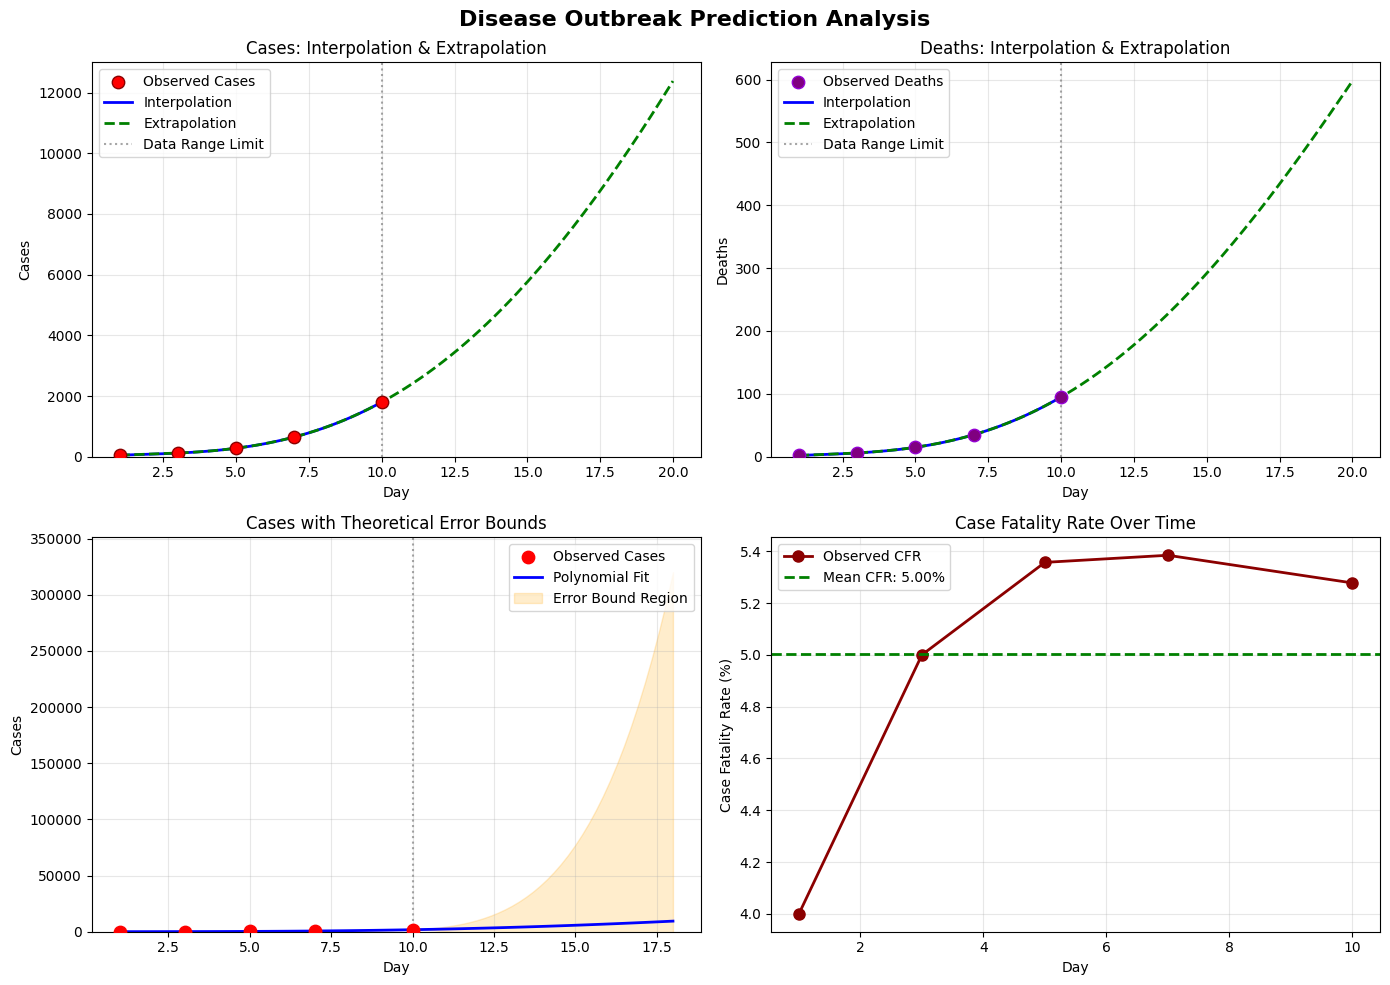


Visualization complete: 4 plots generated.


In [11]:
# 11. VISUALIZATION
# -----------------

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Outbreak Prediction Analysis',
             fontsize=16, fontweight='bold')

# X ranges for interpolation and extrapolation
x_interp = np.linspace(predictor.days.min(), predictor.days.max(), 100)
x_extrap = np.linspace(predictor.days.min(), 20, 150)

y_interp_cases = predictor.interpolator_cases.evaluate(x_interp)
y_extrap_cases = predictor.interpolator_cases.evaluate(x_extrap)

# Plot 1: Cases
ax1 = axes[0, 0]
ax1.scatter(predictor.days, predictor.case_data, color='red', s=80,
            label='Observed Cases', zorder=5, edgecolors='darkred')
ax1.plot(x_interp, y_interp_cases, 'b-', linewidth=2, label='Interpolation')
ax1.plot(x_extrap, y_extrap_cases, 'g--', linewidth=2, label='Extrapolation')
ax1.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.7,
            label='Data Range Limit')
ax1.set_xlabel('Day')
ax1.set_ylabel('Cases')
ax1.set_title('Cases: Interpolation & Extrapolation')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(bottom=0)

# Plot 2: Deaths
ax2 = axes[0, 1]
y_interp_deaths = predictor.interpolator_deaths.evaluate(x_interp)
y_extrap_deaths = predictor.interpolator_deaths.evaluate(x_extrap)

ax2.scatter(predictor.days, predictor.death_data, color='purple', s=80,
            label='Observed Deaths', zorder=5, edgecolors='darkviolet')
ax2.plot(x_interp, y_interp_deaths, 'b-', linewidth=2, label='Interpolation')
ax2.plot(x_extrap, y_extrap_deaths, 'g--', linewidth=2, label='Extrapolation')
ax2.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.7,
            label='Data Range Limit')
ax2.set_xlabel('Day')
ax2.set_ylabel('Deaths')
ax2.set_title('Deaths: Interpolation & Extrapolation')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(bottom=0)

# Plot 3: Cases with Error Bounds
ax3 = axes[1, 0]
x_error = np.linspace(predictor.days.min(), 18, 80)
error_bounds_list = [
    OutbreakErrorAnalysis.error_bound_estimate(
        predictor.days, predictor.case_data, x
    ) for x in x_error
]
y_pred_error = predictor.interpolator_cases.evaluate(x_error)

ax3.scatter(predictor.days, predictor.case_data, color='red', s=80,
            label='Observed Cases', zorder=5)
ax3.plot(x_error, y_pred_error, 'b-', linewidth=2, label='Polynomial Fit')
ax3.fill_between(x_error,
                 y_pred_error - np.array(error_bounds_list),
                 y_pred_error + np.array(error_bounds_list),
                 color='orange', alpha=0.2, label='Error Bound Region')
ax3.axvline(predictor.days.max(), color='gray', linestyle=':', alpha=0.7)
ax3.set_xlabel('Day')
ax3.set_ylabel('Cases')
ax3.set_title('Cases with Theoretical Error Bounds')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(bottom=0)

# Plot 4: Case Fatality Rate (CFR)
ax4 = axes[1, 1]
case_fatality_rate = (predictor.death_data / predictor.case_data) * 100.0
ax4.plot(predictor.days, case_fatality_rate, 'o-',
         color='darkred', linewidth=2, markersize=8, label='Observed CFR')
ax4.axhline(np.mean(case_fatality_rate), color='green', linestyle='--',
            linewidth=2, label=f'Mean CFR: {np.mean(case_fatality_rate):.2f}%')
ax4.set_xlabel('Day')
ax4.set_ylabel('Case Fatality Rate (%)')
ax4.set_title('Case Fatality Rate Over Time')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print("\nVisualization complete: 4 plots generated.")


## Comprehensive Results Summary
This code cell prints a textual report summarizing results.

In [12]:
# 12. COMPREHENSIVE RESULTS SUMMARY
# ---------------------------------

print("\n" + "="*70)
print("COMPREHENSIVE OUTBREAK PREDICTION REPORT")
print("="*70)

print("\n1. DATA SUMMARY")
print("-"*70)
print(f"Total observed data points: {len(predictor.days)}")
print(f"Time period: Days {predictor.days.min():.0f} to {predictor.days.max():.0f}")
print(f"Total cases (observed): {predictor.case_data.sum():.0f}")
print(f"Total deaths (observed): {predictor.death_data.sum():.0f}")
print(f"Overall Case Fatality Rate: {(predictor.death_data.sum()/predictor.case_data.sum()*100):.2f}%")

print("\n2. INTERPOLATION RESULTS")
print("-"*70)
print(f"Days interpolated: {len(days_to_interpolate)}")
interpolated_total = np.sum(predictor.interpolate(days_to_interpolate, 'cases'))
print(f"Estimated total cases in interpolated days: {interpolated_total:.0f}")

print("\n3. EXTRAPOLATION RESULTS")
print("-"*70)
print(f"Days extrapolated: {len(future_days)}")
future_predictions = predictor.extrapolate(future_days, 'cases')
print(f"Predicted total cases in future days: {future_predictions.sum():.0f}")
print(f"Maximum predicted daily cases: {future_predictions.max():.0f}")
print(f"Day of maximum predicted cases: Day {future_days[np.argmax(future_predictions)]:.0f}")

print("\n4. GROWTH ANALYSIS")
print("-"*70)
initial_cases = predictor.case_data[0]
final_cases = predictor.case_data[-1]
growth_factor = final_cases / initial_cases
days_elapsed = predictor.days[-1] - predictor.days[0]
doubling_time = days_elapsed * np.log(2) / np.log(growth_factor)

print(f"Growth factor (initial to final): {growth_factor:.2f}x")
print(f"Days elapsed between first and last point: {days_elapsed:.0f} days")
print(f"Estimated doubling time (approx.): {doubling_time:.2f} days")

print("\n5. ERROR ASSESSMENT (BASED ON SYNTHETIC TRUTH)")
print("-"*70)
print(f"Mean Absolute Error (MAE): {mae:.2f} cases")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} cases")
print(f"Average Relative Error: {np.mean(rel_errors)*100:.2f}%")

print("\n6. QUALITATIVE RECOMMENDATIONS")
print("-"*70)
print("✓ Interpolation Inside Observed Range (High Confidence)")
print("  - Use for estimating missing days between observed data points.")
print("  - Errors and error bounds are relatively small and stable.")

print("\n⚠ Short-Term Extrapolation (Moderate Confidence)")
print("  - Reasonable up to a few days beyond the last observed day.")
print("  - Error bounds increase but may still be acceptable for rough forecasting.")

print("\n✗ Long-Term Extrapolation (Low Confidence)")
print("  - Not recommended far beyond the observed time range.")
print("  - Real outbreaks change dynamically and are not purely polynomial.")

print("\n" + "="*70)
print("END OF REPORT")
print("="*70)


COMPREHENSIVE OUTBREAK PREDICTION REPORT

1. DATA SUMMARY
----------------------------------------------------------------------
Total observed data points: 5
Time period: Days 1 to 10
Total cases (observed): 2900
Total deaths (observed): 153
Overall Case Fatality Rate: 5.28%

2. INTERPOLATION RESULTS
----------------------------------------------------------------------
Days interpolated: 4
Estimated total cases in interpolated days: 1640

3. EXTRAPOLATION RESULTS
----------------------------------------------------------------------
Days extrapolated: 4
Predicted total cases in future days: 24122
Maximum predicted daily cases: 9438
Day of maximum predicted cases: Day 18

4. GROWTH ANALYSIS
----------------------------------------------------------------------
Growth factor (initial to final): 36.00x
Days elapsed between first and last point: 9 days
Estimated doubling time (approx.): 1.74 days

5. ERROR ASSESSMENT (BASED ON SYNTHETIC TRUTH)
-------------------------------------------